In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import lightgbm as lgb

In [1]:
%pip install lightgbm

   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ------- -------------------------------- 0.3/1.5 MB ? eta -:--:--
   -------------- ------------------------- 0.5/1.5 MB 1.3 MB/s eta 0:00:01
   --------------------- ------------------ 0.8/1.5 MB 1.3 MB/s eta 0:00:01
   ---------------------------- ----------- 1.0/1.5 MB 1.3 MB/s eta 0:00:01
   ------------------------------------ --- 1.3/1.5 MB 1.2 MB/s eta 0:00:01
   ---------------------------------------- 1.5/1.5 MB 1.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
trainPath = r"C:\Users\R\Downloads\archive(16)\train.csv"
testPath = r"C:\Users\R\Downloads\archive(16)\test.csv"

train = pd.read_csv(trainPath, parse_dates=['Date'])
test = pd.read_csv(testPath, parse_dates=['Date'])

train = train.sort_values(['Store','Dept','Date'])
test = test.sort_values(['Store','Dept','Date'])

In [4]:
for df in [train, test]:
    df["week"] = df["Date"].dt.isocalendar().week.astype(int)
    df["month"] = df["Date"].dt.month
    df["year"] = df["Date"].dt.year
    df["dayofweek"] = df["Date"].dt.dayofweek

In [5]:
def add_lags(df):
    df = df.copy()
    grp = df.groupby(["Store","Dept"])
    for lag in [1, 2, 4, 8, 12, 52]:
        df[f"lag_{lag}"] = grp["Weekly_Sales"].shift(lag)
    for win in [4, 12, 52]:
        df[f"roll_mean_{win}"] = grp["Weekly_Sales"].shift(1).rolling(win).mean()
    return df

train = add_lags(train)

In [6]:
panel = pd.concat([train, test.assign(Weekly_Sales=np.nan)])
panel = add_lags(panel)
train = panel[panel["Weekly_Sales"].notna()].copy()
test  = panel[panel["Weekly_Sales"].isna()].copy()

train = train.dropna()

In [7]:
x = train.drop(columns=["Weekly_Sales","Date"])
y = train['Weekly_Sales']

tscv = TimeSeriesSplit(n_splits=5)
for train_idx, val_idx in tscv.split(x):
  x_train, x_val = x.iloc[train_idx], x.iloc[val_idx]
  y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
  break

In [12]:
model = lgb.LGBMRegressor(
  n_estimators = 1000,
  learning_rate = 0.05,
  subsample = 0.8,
  random_state = 42
)

model.fit(x_train, y_train,
          eval_set = [(x_val, y_val)],
          eval_metric = 'rmse')

y_pred = model.predict(x_val)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
print("Validation RMSE:", rmse)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002996 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2449
[LightGBM] [Info] Number of data points in the train set: 43518, number of used features: 15
[LightGBM] [Info] Start training from score 18125.422258
Validation RMSE: 4573.557063464696


In [ ]:
x_test = test.drop(columns=["Weekly_Sales","Date"])
test["Weekly_Sales"] = model.predict(x_test)

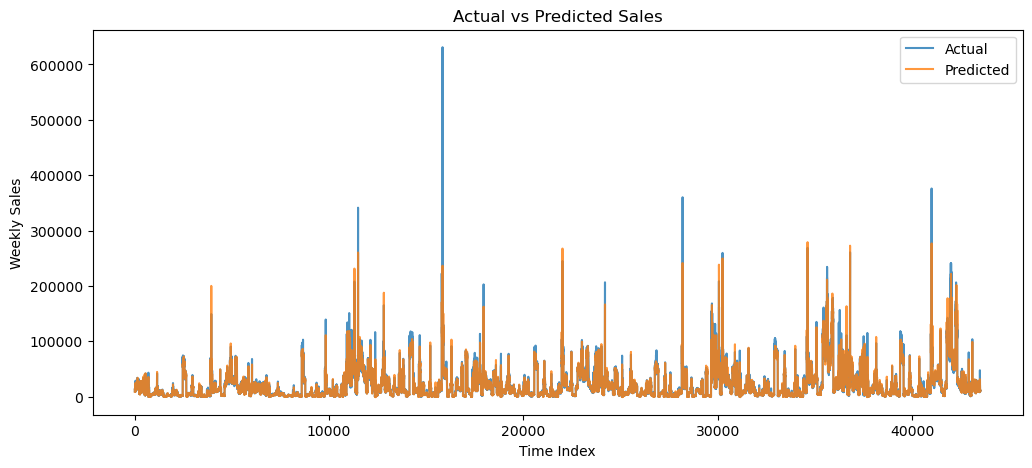

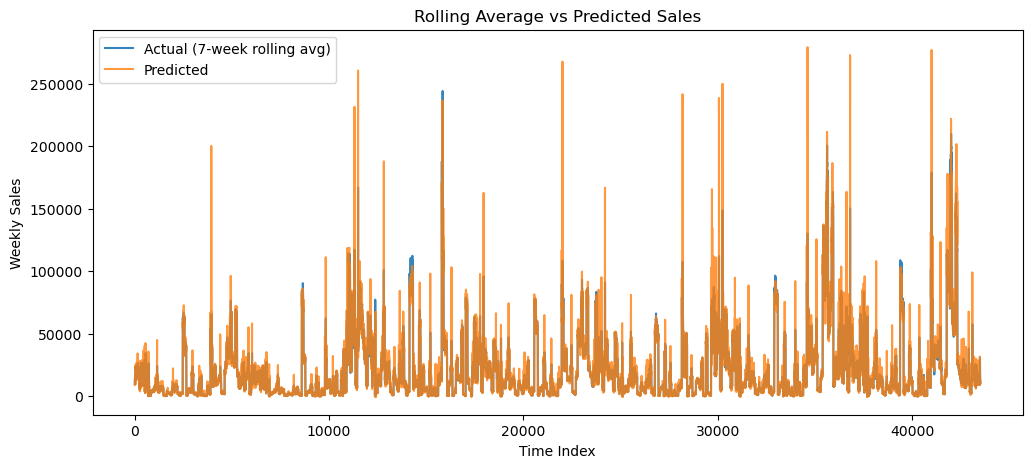

In [13]:
import matplotlib.pyplot as plt

val_results = pd.DataFrame({
    "Actual": y_val,
    "Predicted": y_pred
})
val_results = val_results.reset_index(drop=True)

val_results["Actual_Rolling"] = val_results["Actual"].rolling(window=7, min_periods=1).mean()

plt.figure(figsize=(12,5))
plt.plot(val_results["Actual"], label="Actual", alpha=0.8)
plt.plot(val_results["Predicted"], label="Predicted", alpha=0.8)
plt.title("Actual vs Predicted Sales")
plt.xlabel("Time Index")
plt.ylabel("Weekly Sales")
plt.legend()
plt.show()

plt.figure(figsize=(12,5))
plt.plot(val_results["Actual_Rolling"], label="Actual (7-week rolling avg)", alpha=0.9)
plt.plot(val_results["Predicted"], label="Predicted", alpha=0.8)
plt.title("Rolling Average vs Predicted Sales")
plt.xlabel("Time Index")
plt.ylabel("Weekly Sales")
plt.legend()
plt.show()